In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from s3fs.core import S3FileSystem
from tqdm import tqdm

def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=2.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
        # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]
    
    
    plt.figure(figsize=(15, 7))
    map = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=75)
    map.drawcoastlines()
    map.drawcountries()
    map.drawlsmask(ocean_color="aqua",
                   resolution = 'l')
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    #plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

## Save the necessary files

In [2]:
%%time

# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation/"
save_dir = "/glade/scratch/zhonghua/model-validation-diff/"
diff_by_lat_lon_ls = []

for i in tqdm(range(2,34)):
        member = (str(i).zfill(3))
        #print("member:",member)

        df_2006=pd.read_csv(validation_path+"2006/"+member+"_ens.csv")
        diff_by_lat_lon_2006 = df_2006.groupby(["lat","lon"])\
                                   .apply(lambda df_2006: 
                                          np.mean(df_2006[member]-df_2006["TREFMXAV_U"]))

        df_2061=pd.read_csv(validation_path+"2061/"+member+"_ens.csv")
        diff_by_lat_lon_2061 = df_2061.groupby(["lat","lon"])\
                                   .apply(lambda df_2061: 
                                          np.mean(df_2061[member]-df_2061["TREFMXAV_U"]))
        
        diff_by_lat_lon_ls.append(diff_by_lat_lon_2061 - diff_by_lat_lon_2006)
        
        del df_2006, df_2061, diff_by_lat_lon_2006, diff_by_lat_lon_2061
        gc.collect()
        
diff_by_lat_lon=pd.concat(diff_by_lat_lon_ls,axis=1)
diff_by_lat_lon.to_csv(save_dir+"diff_by_lat_lon.csv")

100%|██████████| 32/32 [12:56<00:00, 24.26s/it]


CPU times: user 11min 24s, sys: 1min 30s, total: 12min 54s
Wall time: 12min 56s


## visualization

In [3]:
# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation/"
save_dir = "/glade/scratch/zhonghua/model-validation-diff/"
df = pd.read_csv(save_dir+"diff_by_lat_lon.csv")
df_mean = df.set_index(["lat","lon"]).mean(axis=1)

,lat,lon,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
count,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,...,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,-0.008376,-0.002396,0.000667,0.014154,0.008239,-0.005160,-0.006859,-0.008360,...,0.004521,0.007068,0.004242,0.002576,-0.001534,0.007974,0.004801,-0.011052,0.012634,-0.005634
std,25.646228,111.895429,0.076076,0.078903,0.075319,0.073700,0.075069,0.075157,0.080836,0.075890,...,0.081133,0.078185,0.084514,0.075364,0.072839,0.075869,0.078507,0.074637,0.079718,0.075127
min,-54.188499,0.000000,-0.413660,-0.497397,-0.357042,-0.372556,-0.555687,-0.564178,-0.514868,-0.470709,...,-0.723756,-0.387331,-0.525511,-0.458922,-0.465802,-0.477134,-0.423192,-0.441792,-0.482857,-0.718084
25%,8.952900,36.250000,-0.044925,-0.033828,-0.037216,-0.022587,-0.027493,-0.037377,-0.043402,-0.042626,...,-0.035492,-0.030294,-0.036433,-0.033395,-0.030958,-0.031241,-0.029051,-0.040413,-0.024712,-0.040672
50%,29.685900,100.000000,-0.006797,0.000246,-0.000081,0.011794,0.003675,-0.001220,-0.008506,-0.007899,...,-0.002632,0.001308,0.001377,0.002576,0.001310,0.004513,0.004625,-0.005401,0.010408,-0.006398
75%,42.879601,260.000000,0.030070,0.034791,0.036733,0.051823,0.041995,0.030227,0.031795,0.027788,...,0.035553,0.040644,0.040856,0.038261,0.035522,0.041709,0.040209,0.024852,0.051582,0.030344
max,70.209396,358.750000,0.436898,0.436382,0.429138,0.431369,0.445663,0.413358,0.526044,0.446036,...,0.524108,0.584691,0.500399,0.480906,0.402612,0.568163,0.571846,0.455452,0.537146,0.380209


count    4439.000000
mean       -0.000112
std         0.014082
min        -0.154579
25%        -0.007600
50%        -0.000470
75%         0.007410
max         0.089001
dtype: float64

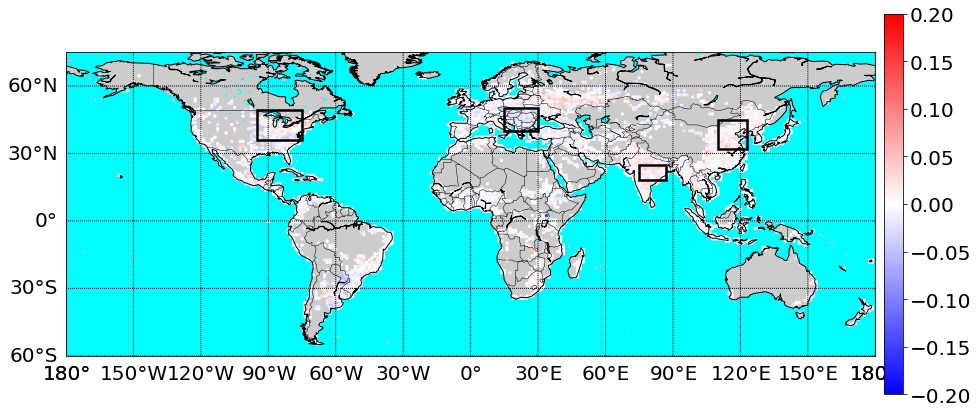

In [4]:
display(df.describe())
display(df_mean.describe())
global_map_plot(df_mean.reset_index(), 0, -0.2, 0.2, "bwr","")